# American Dialect Classification with Extreme Learning Machines

This notebook is my implementation of the approach described in *"Word Based Dialect Classification using Extreme Learning Machines"* by Rizwan et al. (2016).

The acoustic characteristics that define American dialects have been a long standing interest of mine, and building a classifier seemed like a fun way to explore this. However, I struggled with the limitations that TIMIT presented and wasn’t able to make much progress with my models. To overcome this, I decided to work through this paper as a learning exercise; to deepen my understanding of the techniques the authors used, and to serve as a useful reference point for experimenting with other approaches.


| Region # | Region name              | # Speakers |
|----------|--------------------------|------------|
| DR1      | New England              | 49         |
| DR2      | Northern                 | 102        |
| DR3      | North Midland            | 102        |
| DR4      | South Midland            | 100        |
| DR5      | Southern                 | 98         |
| DR6      | New York City            | 46         |
| DR7      | Western                  | 100        |

### Feature Extraction

In [205]:
import glob
import librosa
import numpy as np

DATA_PATH = "../data/processed/words"
N_REGIONS = 7 # ignore army brat
words = ["she", "had", "your", "dark", "suit", "greasy", "wash", "water", "year", # SA1
         "dont", "ask", "carry", "oily", "rag", "like", "that"] # SA2

n_mfcc = 13
sr = 16000
n_fft = int(0.025 * sr)
hop_length = int(0.01 * sr)
win_length = n_fft

def extract_features(wav):
    """
    Extract MFCC + delta + delta-delta
    Output shape: (T, 39)
    """
    y, _ = librosa.load(wav, sr=sr)

    if len(y) == 0:
        return None

    # peak normalization
    peak = np.max(np.abs(y))
    y = y / peak if peak > 0 else y

    mfcc = librosa.feature.mfcc(y=y,
                                sr=sr,
                                n_mfcc=n_mfcc,
                                n_mels=26,
                                n_fft=n_fft,
                                hop_length=hop_length,
                                win_length=win_length,
                                window="hamming",
                                htk=True,
                                norm=None)  # (13, T)

    delta  = librosa.feature.delta(mfcc, width=5)
    delta2 = librosa.feature.delta(mfcc, width=5, order=2)

    # concatenate to get (39, T) --> (T, 39)
    features = np.vstack([mfcc, delta, delta2]).T

    return features


def get_data():
    data = {
        "train": {},
        "test": {}
    }
    
    for split in ["TRAIN", "TEST"]:
        s = split.lower()
        paths = []
        
        for d in range(1, N_REGIONS + 1):
            for word in words:
                paths += glob.glob(f'{DATA_PATH}/{split}/DR{d}/*/*_{word}.wav')

        for wav in paths:
            
            path_split = wav.split("/")
            dialect = int(path_split[5][2]) - 1
            speaker = path_split[6]
            word = path_split[7].split("_")[3].replace(".wav", "")

            features = extract_features(wav) # (T, 39)
    
            if speaker not in data[s]:
                data[s][speaker] = {
                    "dialect": dialect,
                    "words": {}
                }

            if features is not None:
                data[s][speaker]["words"][word] = features

    return data

data = get_data()

In [206]:
# Should be (T, 39)
data["train"]["MRBC0"]["words"]["dark"].shape

(28, 39)

### Single Model Experiment

In [207]:
from hpelm import ELM
import os
import sys
from contextlib import redirect_stdout

n_features = (n_mfcc + 0) * 3 # 39

def get_samples(data, split, word, d1, d2):
    c1, c2 = [], []

    for speaker in data[split].values():
        if word not in speaker["words"]:
            continue
        if speaker["dialect"] == d1:
            c1.append(speaker["words"][word])
        elif speaker["dialect"] == d2:
            c2.append(speaker["words"][word])

    return c1, c2

def append_class_samples(features_1, features_2):

    X = []
    y = []
    
    for sample in features_1:
        X.append(sample)
        y.append(np.full(sample.shape[0], 0))

    for sample in features_2:
        X.append(sample)
        y.append(np.full(sample.shape[0], 1))

    X = np.vstack(X)
    y = np.hstack(y)

    return X, y

def onehot(y, num_classes=2):
    y_onehot = y_onehot = np.zeros((y.size, num_classes))
    y_onehot[np.arange(y.size), y] = 1
    
    return y_onehot

def get_weights(class_1, class_2):
    """ Inverse class frequency """
    n1 = sum(sample.shape[0] for sample in class_1)
    n2 = sum(sample.shape[0] for sample in class_2)
    total = n1 + n2
    return np.array([total / (2 * n1), total / (2 * n2)])

class_1, class_2 = get_samples(data, "train", "dark", 0, 1)
t_1, t_2 = get_samples(data, "test", "dark", 0, 1)
weights = get_weights(class_1, class_2)

X_train, y_train = append_class_samples(class_1, class_2)
X_test, y_test = append_class_samples(t_1, t_2)

# cmvn
mean = X_train.mean(axis=0, keepdims=True)
std = X_train.std(axis=0, keepdims=True) + 1e-8
X_train = (X_train - mean) / std

# train
elm_d1_d2 = ELM(n_features, 2)
elm_d1_d2.add_neurons(1000, "sigm")
with open(os.devnull, "w") as f, redirect_stdout(f):
    error = elm_d1_d2.train(X_train, onehot(y_train), 'CV', 'wc', w=weights, k=10)

# eval
X_test = (X_test - mean) / std
y_pred = elm_d1_d2.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = np.mean(y_pred_labels == y_test)

print(f"Frame level accuracy: {accuracy * 100:.2f}%\nError: {error}")

Frame level accuracy: 62.29%
Error: 0.36974415652692005


### Single Word Pairwise ELM Classification

In [208]:
def build_pairwise_elms(word, n_units=1000, log=False):
    pairwise_elms = {}

    for i in range(N_REGIONS):
        for j in range(i + 1, N_REGIONS):

            elm_name = f'DR{i + 1}, DR{j + 1}'

            class_1, class_2 = get_samples(data, "train", "dark", i, j)
            X, y = append_class_samples(class_1, class_2)

            # handle class imbalance 
            weights = get_weights(class_1, class_2)

            # cmvn
            mean = X.mean(axis=0, keepdims=True)
            std = X.std(axis=0, keepdims=True) + 1e-8
            X = (X - mean) / std

            y_oh = onehot(y)

            elm = ELM(n_features, 2)
            elm.add_neurons(n_units, "sigm")
            with open(os.devnull, "w") as f, redirect_stdout(f):
                error = elm.train(X, y_oh, 'CV', 'wc', w=weights, k=10)

            pairwise_elms[elm_name] = (elm, mean, std, i, j)

            if log:
                print(f'{elm_name} : {error}')

    return pairwise_elms

In [223]:
def count_to_score(count):
    """
    Assumes class will have 1 - 6 votes.
    """
    mapping = {6 : 2 ** 1,
               5 : 2 ** 0,
               4 : 2 ** -1,
               3 : 2 ** -2,
               2 : 2 ** -3,
               1 : 2 ** -4,
               0 : 0}

    return np.array(list(map(lambda x: mapping[x], count)))

def classify_sample(X, pairwise_elms):
    """
    Tallies binary classifier votes for a word sample.
    Returns scores.
    """
    count = np.array([0, 0, 0, 0, 0, 0, 0])
    
    for elm, mean, std, class_1, class_2 in pairwise_elms.values():

        X_test = (X - mean) / std
        
        y_pred = elm.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1) # frame level predictions
        y_pred_label = np.bincount(y_pred).argmax() # overall prediction

        count[(class_1, class_2)[y_pred_label]] += 1
    
    return count_to_score(count)

def eval_word(data, word, pairwise_elms):
    decisions = []

    for speaker in data["test"]:
        dialect = data["test"][speaker]["dialect"]
        decision = classify_sample(data["test"][speaker]["words"][word], pairwise_elms)
        decision = np.argmax(decision)
        decisions.append(1 if decision == dialect else 0)

    decisions = np.array(decisions)
    accuracy = np.mean(decisions)

    return accuracy * 100

In [217]:
elms_dark = build_pairwise_elms("dark", 300, True)
print(eval_word(data, "dark", elms_dark))

DR1, DR2 : 0.4335136644247631
DR1, DR3 : 0.4085477798473047
DR1, DR4 : 0.3635456387941999
DR1, DR5 : 0.35859787496622
DR1, DR6 : 0.35749784648898136
DR1, DR7 : 0.41893195884263196
DR2, DR3 : 0.4302338488711327
DR2, DR4 : 0.36867619457909007
DR2, DR5 : 0.32266642531297274
DR2, DR6 : 0.4323295908818201
DR2, DR7 : 0.4323048567057585
DR3, DR4 : 0.43359293749892314
DR3, DR5 : 0.37520213643250294
DR3, DR6 : 0.45459731949932497
DR3, DR7 : 0.4504726848420251
DR4, DR5 : 0.43253721229549524
DR4, DR6 : 0.4530121799246909
DR4, DR7 : 0.3941189971924855
DR5, DR6 : 0.5006621953087937
DR5, DR7 : 0.3622248336639931
DR6, DR7 : 0.45249878514195874
28.02547770700637


In [220]:
def run_trials(word, n_units=1000, n_runs=10):
    """
    Train and evaluate word level classifiers multiple times, report statistics,
    and return the one with the highest accuracy.
    
    Returns:
        dict[str, tuple[Model, np.ndarray, np.ndarray, str, str]]: maps class pair to tuple containing binary classifier, 
        mean, std, and individual class labels
    """
    results = []
    
    for _ in range(n_runs):
        elms = build_pairwise_elms(word, n_units)
        acc = eval_word(data, word, elms)
    
        results.append((acc, elms))

    accuracies = [acc for acc, _ in results]
    print(f'--- {word} ---\nMean: {np.mean(accuracies)}'
          f'\nStd: {np.std(accuracies)} \nMax: {max(accuracies)}'
          f'\nMin: {min(accuracies)} \n')

    _ , best_elms = max(results, key=lambda x: x[0])
    
    return best_elms

In [226]:
elms_dark = run_trials("dark", 300, 5)

--- dark ---
Mean: 30.95541401273885
Std: 1.0349093509090392 
Max: 32.48407643312102
Min: 29.29936305732484 



### 5 Word Utterance Level Classification

Utterance level classification using 5 words from SA1, specifically: \['dark', 'water', 'greasy', 'suit', 'wash'\]

In [200]:
sa1_5 = {}
sa1_5_words = ['dark', 'water', 'greasy', 'suit', 'wash']

for word in sa1_5_words:
    sa1_5[word] = run_trials(word, 10)

--- dark ---
Mean: 30.31847133757962
Std: 3.262738464933935 
Max: 35.6687898089172
Min: 24.203821656050955 

--- water ---
Mean: 19.426751592356688
Std: 1.1830685108921482 
Max: 21.019108280254777
Min: 17.197452229299362 

--- greasy ---
Mean: 15.987261146496815
Std: 1.5974441024184016 
Max: 18.471337579617835
Min: 13.375796178343949 

--- suit ---
Mean: 13.630573248407643
Std: 2.0580247670577716 
Max: 16.560509554140125
Min: 10.191082802547772 

--- wash ---
Mean: 16.878980891719745
Std: 1.7150206392148106 
Max: 19.745222929936308
Min: 13.375796178343949 



In [ ]:
def eval_utterance(data, pairwise_elms, words):

    decisions = [[], [], [], [], [], [], []]

    for speaker in data["test"]:
        utt_scores = np.array([0, 0, 0, 0, 0, 0, 0])
        dialect = data["test"][speaker]["dialect"]
        
        for word in words:
            sample = data["test"][speaker]["words"][word]
            sample_scores = classify_sample(sample, pairwise_elms[word])
            utt_scores = utt_scores + sample_scores

        decision = np.argmax(utt_scores)
        decisions[dialect].append(1 if decision == dialect else 0)

    tot_acc = np.mean(np.concatenate(decisions))
    d_acc = list(map(np.mean, decisions))

    return tot_acc, d_acc

tot_acc, d_acc = eval_utterance(data, sa1_5, sa1_5_words)
print(f'Overall accuracy: {tot_acc * 100}')

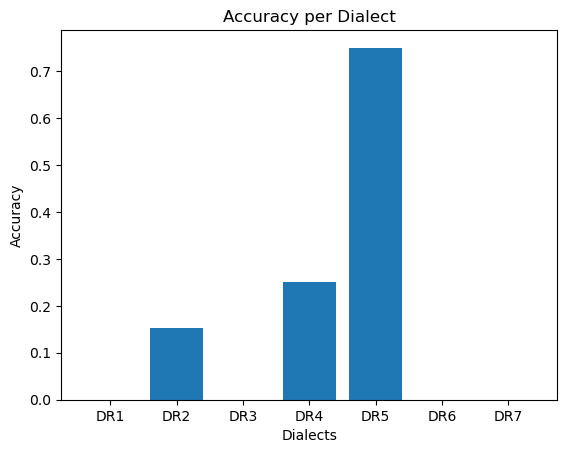

In [204]:
import matplotlib.pyplot as plt

labels = ["DR1", "DR2", "DR3", "DR4", "DR5", "DR6", "DR7"]

plt.bar(labels, d_acc)
plt.title('Accuracy per Dialect')
plt.xlabel('Dialects')
plt.ylabel('Accuracy')
plt.show()

### References

1. Garofolo, John S., et al. TIMIT Acoustic-Phonetic Continuous Speech Corpus LDC93S1. Web 
Download. Philadelphia: Linguistic Data Consortium, 1993.

2. Rizwan, M., Odelowo, B. O., & Anderson, D. V. (2016, July). Word based dialect classification using extreme learning machines. In 2016 International Joint Conference on Neural Networks (IJCNN) (pp. 2625-2629). IEEE.